# Optimization with Synthetic Data
In this notebook, optimization is performed with an SBML model and [PEtab](https://github.com/PEtab-dev/PEtab) parameter estimation problem, which includes some measurements.

Next, optimization is performed with synthetic data as measurements, which is generated using PEtab and [AMICI](https://github.com/AMICI-dev/AMICI). The ability to recover the parameter vector that was used to generate the synthetic data is demonstrated.

## Requirements
Additional requirements for this notebook can be installed with `pip install amici petab`.

In [1]:
import amici.petab_simulate
import matplotlib.pyplot as plt
import petab
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Helper function to get the maximum likelihood estimate as a dictionary from a pyPESTO optimization result.
def get_x_mle(optimize_result, pypesto_problem, petab_problem, scaled=True):
    if not scaled:
        scaling = petab.parameters.get_optimization_parameter_scaling(petab_problem.parameter_df)
    return {
        x_id: (petab.parameters.unscale(x_value, scaling[x_id]) if not scaled else x_value)
        for x_id, x_value in zip(pypesto_problem.x_names, optimize_result.list[0]['x'])
        #if x_id in scaling
    }

# Standard Optimization
The PEtab problem is used to generate a pyPESTO problem, which is used to estimate model parameters.

In [2]:
petab_yaml_filename = 'conversion_reaction/conversion_reaction.yaml'
petab_problem_original = petab.Problem.from_yaml(petab_yaml_filename)

In [3]:
pypesto_importer_original = pypesto.petab.PetabImporter(petab_problem_original)
pypesto_problem_original = pypesto_importer_original.create_problem()

In [4]:
pypesto_result_original = pypesto.optimize.minimize(pypesto_problem_original, n_starts=100)

Parameters are estimated to be (linear scale):
k1: 0.7755615934245594
k2: 0.5442529678883788


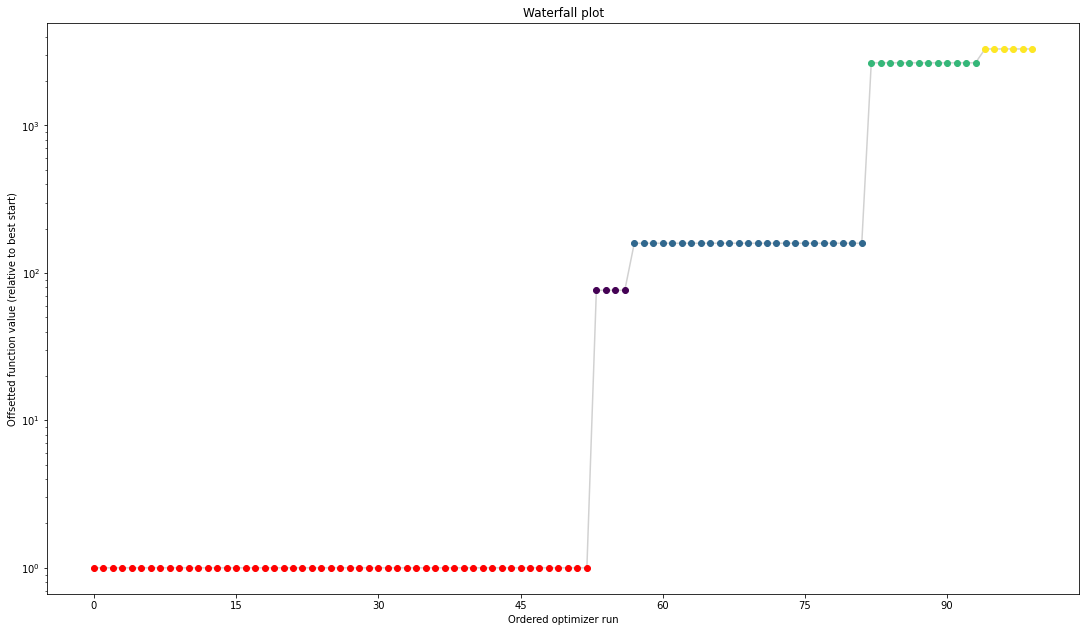

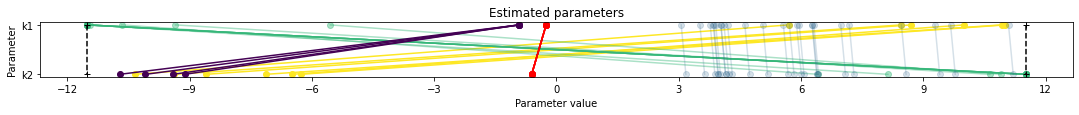

In [5]:
x_mle_unscaled_original = get_x_mle(pypesto_result_original.optimize_result,
                                    pypesto_problem_original,
                                    petab_problem_original,
                                    scaled=False)
print('Parameters are estimated to be (linear scale):')
print('\n'.join([f'{x_id}: {x_value}' for x_id, x_value in x_mle_unscaled_original.items()]))

pypesto.visualize.waterfall(pypesto_result_original);
pypesto.visualize.parameters(pypesto_result_original);

# Synthetic Optimization
Similar to the standard optimization, except the PEtab measurements table is replaced with synthetic data that is generated from specified parameters, with noise, and then used for optimization.

Here, parameters are specified with a dictionary that is used to update the original PEtab parameters table. An alternative is use a second PEtab YAML file that is identical to the original, except for the parameters table, which would now contain the parameter values to be used for synthetic data generation.

## Noise
Noise is added to the simulated data according to the:
- noise distribution in the PEtab observables table;
- noise formula in the PEtab observables table, which is used to calculate the scale of the noise distribution; and
- noise parameters in the PEtab measurements table, which are substituted into the noise formula for measurement-specific noise distribution scales.

In [6]:
petab_problem_synthetic = petab.Problem.from_yaml(petab_yaml_filename)

synthetic_parameters = {'k1': 1.5, 'k2': 2.5}
petab_problem_synthetic.parameter_df[petab.C.NOMINAL_VALUE].update(synthetic_parameters)

simulator = amici.petab_simulate.PetabSimulator(petab_problem_synthetic)
# Optional: the AMICI simulator is provided a model, to avoid recompilation
petab_problem_synthetic.measurement_df = simulator.simulate(
    noise=True,
    noise_scaling_factor=0.01,
    amici_model=pypesto_problem_original.objective.amici_model,
)

In [7]:
pypesto_importer_synthetic = pypesto.petab.PetabImporter(petab_problem_synthetic)
pypesto_problem_synthetic = pypesto_importer_synthetic.create_problem()
pypesto_result_synthetic = pypesto.optimize.minimize(pypesto_problem_synthetic, n_starts=100)

Function values from history and optimizer do not match: 883.7058118316838, 1438.516592125359
Parameters obtained from history and optimizer do not match: [-0.31338411 -2.18798278], [-11.51292546   9.01155858]
Parameters obtained from history and optimizer do not match: [0.40703957 0.91854474], [0.40703201 0.91853685]


Parameters are estimated to be (linear scale):
k1: 1.502363314475298
k2: 2.5056408780674304


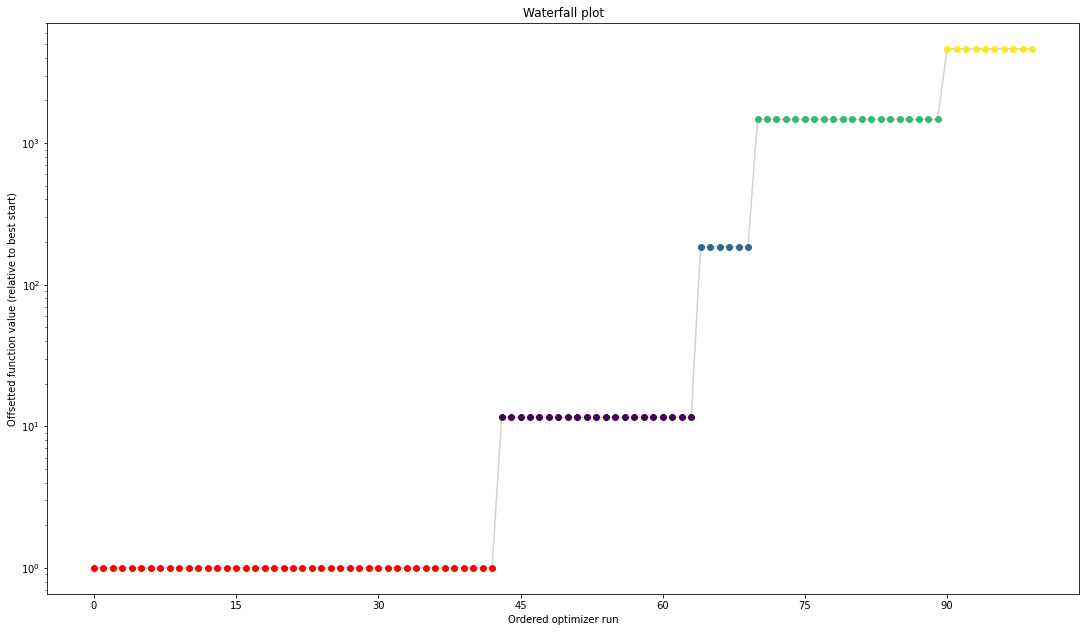

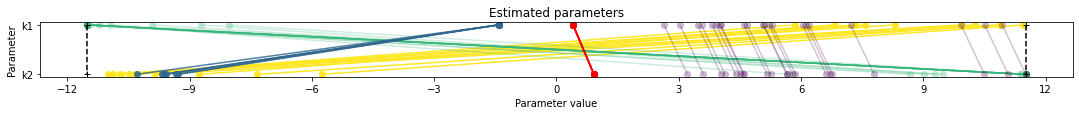

In [8]:
x_mle_unscaled_synthetic = get_x_mle(pypesto_result_synthetic.optimize_result,
                                     pypesto_problem_synthetic,
                                     petab_problem_synthetic,
                                     scaled=False)
print('Parameters are estimated to be (linear scale):')
print('\n'.join([f'{x_id}: {x_value}' for x_id, x_value in x_mle_unscaled_synthetic.items()]))

pypesto.visualize.waterfall(pypesto_result_synthetic);
pypesto.visualize.parameters(pypesto_result_synthetic);